# Heat Equation - FD Implicit

## Finite-difference scheme for the one-dimensional heat equation

We consider here the heat equation on [0, x] × [0, ∞) with boundary conditions 
u(x, 0) = sin(2πx) for all x ∈ [0, x] and 
u(0, t) = u(x, t) = 0 for all t ≥ 0. 

We apply a finite difference scheme, explicit in time and with central difference in space

### Import packages

In [1]:
import numpy as np
from matplotlib import pyplot
%matplotlib inline
from matplotlib import rcParams
rcParams['font.family'] = 'serif'
rcParams['font.size'] = 16

# For sparse matrices
from scipy.sparse import dia_matrix
from scipy.sparse.linalg.dsolve import spsolve

import warnings
warnings.filterwarnings("ignore")

## Implicit Scheme

In [2]:
from scipy.linalg import solve

In [3]:
def generateMatrix(N, sigma):
    """ Computes the matrix for the diffusion equation with backward Euler
        Dirichlet condition at i=0, Neumann at i=-1
    
    Parameters:
    ----------
    T: array of float
        Temperature at current time step
    sigma: float 
        alpha*dt/dx^2
    
    Returns:
    -------
    A: 2D numpy array of float
        Matrix for diffusion equation
    """
   
    # Setup the diagonal
    d = np.diag(np.ones(N-2)*(2+1./sigma))
    
    # Consider Neumann BC
    #d[-1,-1] = 1+1./sigma
    
    # Setup upper diagonal
    ud = np.diag(np.ones(N-3)*-1, 1)
    
    # Setup lower diagonal
    ld = np.diag(np.ones(N-3)*-1, -1)
    
    A = d + ud + ld
    
    return A

In [4]:
def generateRHS(T, sigma, qdx):
    """ Computes right-hand side of linear system for diffusion equation
        with Forward Euler
    
    Parameters:
    ----------
    T: array of float
        Temperature at current time step
    sigma: float
        alpha*dt/dx^2
    qdx: float
        flux at right boundary * dx
    
    Returns:
    -------
    b: array of float
        Right-hand side of diffusion equation with backward Euler
    """
    
    b = T[1:-1]*1./sigma
    # Consider Dirichlet BC
    b[0] += T[0]
    # Consider Neumann BC
    #b[-1] += qdx
    
    return b

In [5]:
def implicit_btcs(T, A, nt, sigma, qdx):
    """ Advances diffusion equation in time with implicit central scheme
   
    Parameters:
    ----------
    T: array of float
        initial temperature profile
    A: 2D array of float
        Matrix with discretized diffusion equation
    nt: int
        number of time steps
    sigma: float
        alpha*td/dx^2
        
    qdx: float
        flux at right boundary * dx
    Returns:
    -------
    T: array of floats
        temperature profile after nt time steps
    """
    
    for t in range(nt):
        Tn = T.copy()
        b = generateRHS(Tn, sigma, qdx)
        # Use numpy.linalg.solve
        T_interior = solve(A,b)
        T[1:-1] = T_interior
        # Enforce Neumann BC (Dirichlet is enforced automatically)
        #T[-1] = T[-2] + qdx

    return T

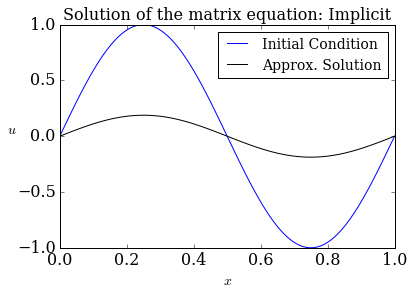

In [6]:
# Set simulation parameters
sigma = 1.0
barX = 1.0
T = 0.1

# Set up grid parameters
nx = 100  # num of grid points
nt = 5000 # num of time steps

dx = barX / (nx - 1)   # Grid step in space
dt = T / nt            # Grid step in time

qdx = 0 # related to Neumann BCs

# Space step size
x = np.linspace(0.0, barX, nx)
# Boundary conditions
Ti = np.sin(2 * np.pi * x)

# Generate matrix
A = generateMatrix(nx, sigma)

# run implicit simulation
T = implicit_btcs(Ti.copy(), A, nt, sigma, qdx) * 100000000  # WHY???


# Initial Condition & solution plot
pyplot.figure()
pyplot.plot(x, Ti, 'b-', label='Initial Condition')
pyplot.plot(x, T, 'k-', label='Approx. Solution')
pyplot.title('Solution of the matrix equation: Implicit', fontsize=16)
pyplot.xlabel(u'$x$', fontsize=14)
pyplot.ylabel(u'$u$', fontsize=14, rotation=0)
pyplot.legend(fontsize=14)
pyplot.show()



## Explicit Scheme

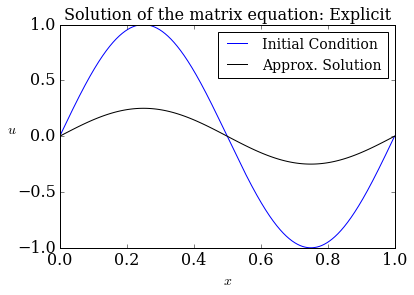

In [7]:
# Set parameters
sigma = 1.0
barX = 1.0
T = 0.1

# Set up grid parameters
nx = 10000  # num of grid points
nt = 5000 # num of time steps

dx = barX / (nx - 1)   # Grid step in space
dt = T / nt            # Grid step in time

# Space step size
x = np.linspace(0.0, barX, nx)
# Boundary conditions
x = np.linspace(0.0, barX, nx)
u = np.sin(2 * np.pi * x)
rhs = np.zeros(nx)

# Definition of the tridiagonal matrix
Tmatrix = [np.ones(nx), 2 *np.ones(nx), np.ones(nx)]
nonzeropositions = np.array([-1, 0, 1])
iterationMatrix = dia_matrix((Tmatrix, nonzeropositions), shape=(nx, nx))

# Solving the linear system
spSolution = spsolve(iterationMatrix, u)

# Initial Condition & solution plot
pyplot.figure()
pyplot.plot(x, u, 'b-', label='Initial Condition')
pyplot.plot(x, spSolution, 'k-', label='Approx. Solution')
pyplot.title('Solution of the matrix equation: Explicit', fontsize=16)
pyplot.xlabel(u'$x$', fontsize=14)
pyplot.ylabel(u'$u$', fontsize=14, rotation=0)
pyplot.legend(fontsize=14)
pyplot.show()
